In [407]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [409]:
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

In [28]:
data = pd.read_parquet('database/')
data = data[(data['merchant_type_code'] == 5732) & (data['transaction_type'] == 'PurchaseActivity')]
data.describe()

,user_id,merchant_type_code,amount_cents,datetime
count,90.000000,90.0,90.000000,90
mean,39677.000000,5732.0,36521.100000,2023-04-02 08:05:53.202711296
min,23933.000000,5732.0,989.000000,2023-03-14 11:57:58.383429
25%,38493.000000,5732.0,6188.000000,2023-03-16 20:44:56.475713280
50%,38493.000000,5732.0,10247.000000,2023-03-28 23:50:18.844785920
75%,38493.000000,5732.0,27836.000000,2023-04-06 11:38:40.095393792
max,96813.000000,5732.0,499975.000000,2023-05-31 07:14:56.676358
std,9130.584829,0.0,69857.259039,NaN


In [107]:
data = data.sort_values(by=['datetime'])

In [380]:
data['date'] = data.loc[:, 'datetime'].dt.date
daily_amt_data = data[['amount_cents', 'date']].groupby(['date']).sum()
daily_avg_data = data[['amount_cents', 'date']].groupby(['date']).mean()
daily_amt_per_user_data = data[['user_id', 'amount_cents', 'date']].groupby(['date', 'user_id']).sum()
may_before = daily_amt_data[daily_amt_data.index < pd.to_datetime("2023-05-01").date()]
may_after = daily_amt_data[daily_amt_data.index >= pd.to_datetime("2023-05-01").date()]

<Axes: xlabel='date'>

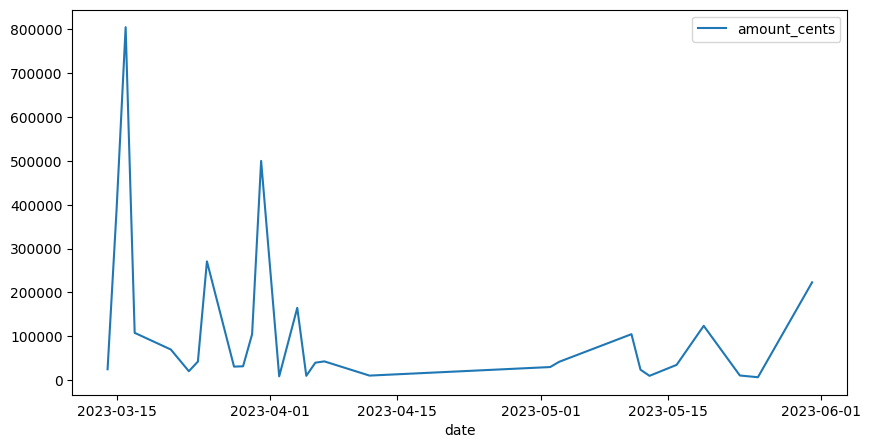

In [96]:
daily_amt_data.plot(y='amount_cents', figsize=(10, 5))

In [186]:
for i in range(1, 8):
    print(i, may_before['amount_cents'].autocorr(i))
    print(i, may_after['amount_cents'].autocorr(i))

1 0.11856001693637667
1 -0.36146118952504547
2 -0.16538995810775373
2 -0.6315133731322895
3 -0.24663369223181947
3 0.6005042670161168
4 -0.0077900315661338145
4 0.42010642727572595
5 0.14630854403708268
5 -0.5155699977964903
6 -0.10586464512554569
6 -0.6995783846290136
7 -0.2877749073700559
7 0.9863774999997154


(array([19429., 19433., 19437., 19441., 19445., 19448., 19452., 19456.,
        19460.]),
 [Text(19429.0, 0, '2023-03-13'),
  Text(19433.0, 0, '2023-03-17'),
  Text(19437.0, 0, '2023-03-21'),
  Text(19441.0, 0, '2023-03-25'),
  Text(19445.0, 0, '2023-03-29'),
  Text(19448.0, 0, '2023-04-01'),
  Text(19452.0, 0, '2023-04-05'),
  Text(19456.0, 0, '2023-04-09'),
  Text(19460.0, 0, '2023-04-13')])

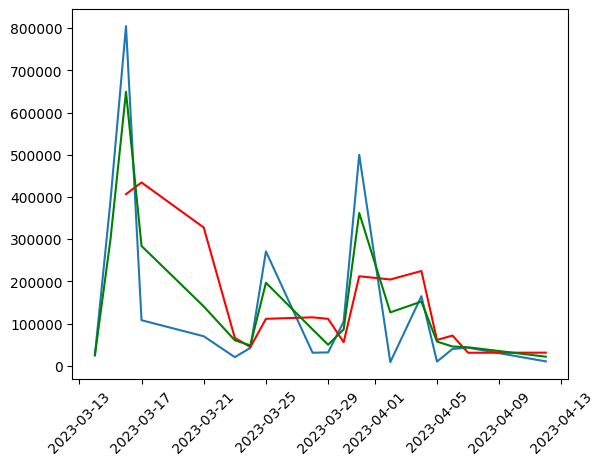

In [187]:
moving_avg = may_before.rolling(3).mean()
exp_ma = may_before.ewm(span=2).mean()
plt.plot(may_before)
plt.plot(moving_avg, color='red')
plt.plot(exp_ma, color='green')
plt.xticks(rotation=45)

In [231]:
#Ho: It is non-stationary
#H1: It is stationary
def adf_test(purchase):
    result=adfuller(purchase)
    print(f"P-Value: {result[1]}" )
    if result[1] <= 0.05:
        print(f"Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print(f"Weak evidence against null hypothesis. Data is non-stationary ")

In [313]:
adf_test(daily_amt_data['amount_cents'])
adf_test(may_before['amount_cents'])
adf_test(may_after['amount_cents'])

P-Value: 0.5875291524314283
Weak evidence against null hypothesis. Data is non-stationary 
P-Value: 0.01004403028833471
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary
P-Value: 0.00030341661177114664
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


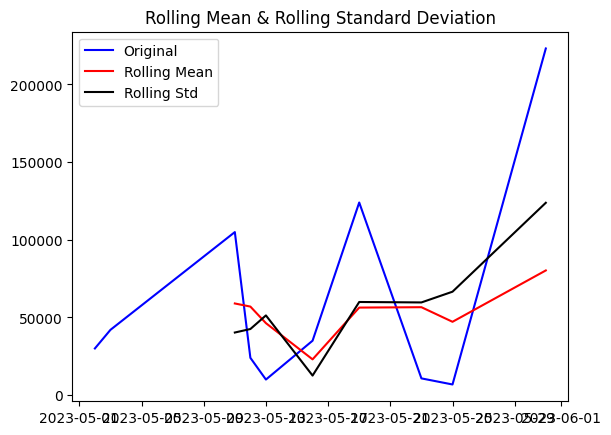

In [310]:
rolling_mean = may_after.rolling(window = 3).mean()
rolling_std = may_after.rolling(window = 3).std()
plt.plot(may_after, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

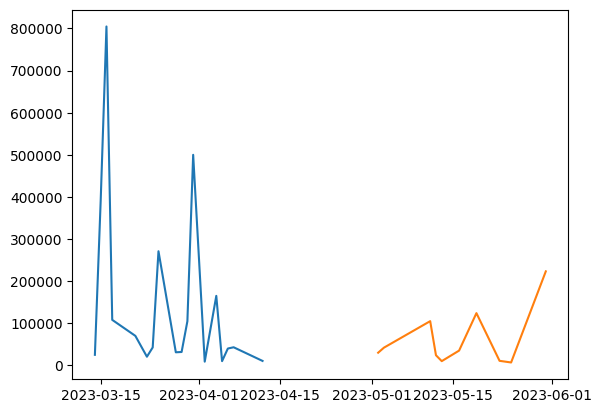

In [183]:
plt.plot(may_before['amount_cents'])
plt.plot(may_after['amount_cents'])

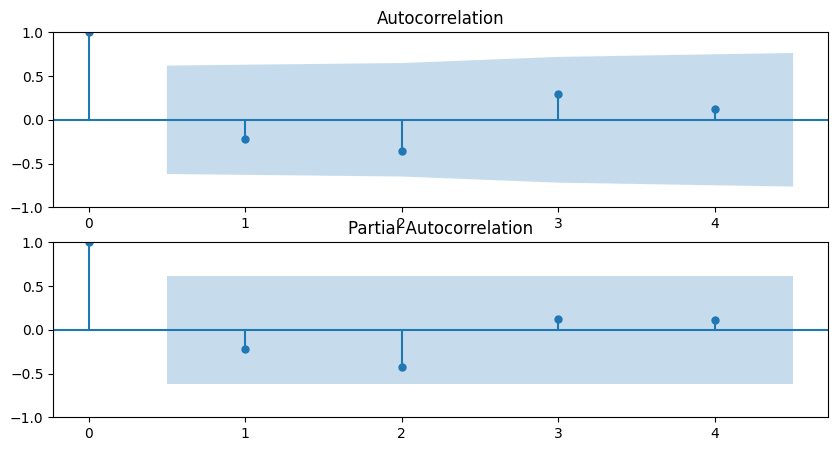

In [271]:

fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(may_after['amount_cents'],lags=4,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(may_after['amount_cents'],lags=4,ax=ax2)


In [398]:
may_after

,amount_cents
date,
2023-05-02,29999
2023-05-03,41984
2023-05-11,104946
2023-05-12,23963
2023-05-13,9975
2023-05-16,34997
2023-05-19,123994
2023-05-23,10724
2023-05-25,6800


In [402]:
stepwise_fit = auto_arima(may_after, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.13 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=254.347, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=255.291, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=256.127, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=258.521, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.03 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 0.202 seconds


In [372]:
target_df = may_after.copy()
target_df.index = pd.DatetimeIndex(target_df.index).to_period('D')

Root Mean Squared Error (RMSE): 62148.21896035453


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           amount_cents   No. Observations:                   10
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -124.662
Date:                Thu, 15 Jun 2023   AIC                            255.323
Time:                        14:43:08   BIC                            256.231
Sample:                    05-02-2023   HQIC                           254.327
                         - 05-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6.106e+04   3.85e+04      1.584      0.113   -1.45e+04    1.37e+05
ar.L1         -0.4415      1.124     -0.393      0.694      -2.644       1.761
sigma2      4.162e+09      0.081   5.11e+10      0.000    4.16e+09    4.16e+09
===================================================================================
Ljung-Box (L1) (Q):                   0.96   Jarque-Bera (JB):                 2.24
Prob(Q):                              0.33   Prob(JB):                         0.33
Heteroskedasticity (H):               8.19   Skew:                             1.14
Prob(H) (two-sided):                  0.12   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.71e+27. Standard errors may be unstable.
"""

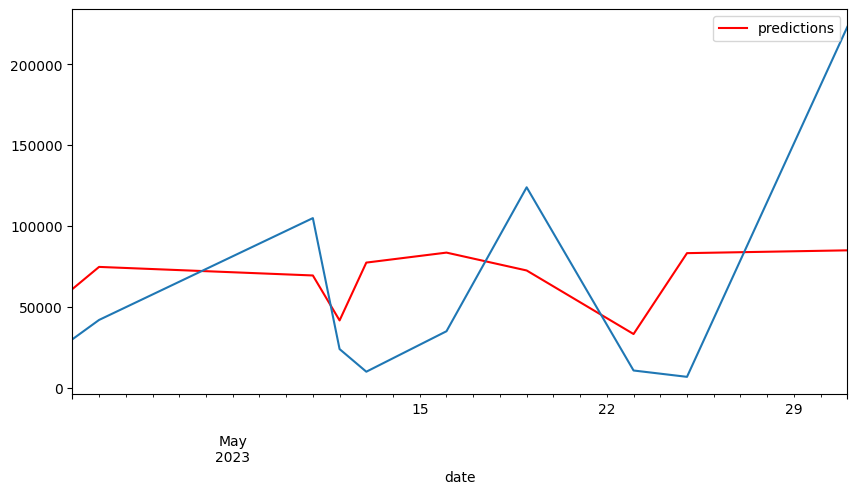

In [400]:
model = ARIMA(target_df, order = (1,0,0))
results = model.fit()
predictions_ARIMA = results.fittedvalues.to_frame().rename(columns={0: 'predictions'})
mse = mean_squared_error(target_df['amount_cents'], predictions_ARIMA)
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE):', rmse)

ax, fig = plt.subplots(figsize=(10, 5))
predictions_ARIMA.plot(ax=fig, color='red')
plt.plot(may_after)
plt.xticks(rotation=45)
results.summary()

In [401]:
results.predict(start=len(daily_amt_data),end=len(daily_amt_data)+15)

2023-05-30    61058.170844
2023-05-31    61058.212818
2023-06-01    61058.194285
2023-06-02    61058.202468
2023-06-03    61058.198855
2023-06-04    61058.200450
2023-06-05    61058.199746
2023-06-06    61058.200057
2023-06-07    61058.199920
2023-06-08    61058.199980
2023-06-09    61058.199954
2023-06-10    61058.199965
2023-06-11    61058.199960
2023-06-12    61058.199962
2023-06-13    61058.199961
2023-06-14    61058.199962
Freq: D, Name: predicted_mean, dtype: float64